In [183]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose

In [99]:
# This cell handles data collection, only run this if you want fresh data
# There is an issue where sometimes the genres of some games gets fetched in different languages,
# This seems to be an issue with Steam's API since we get different languages each time it happens.
# The data file we have provided with the project has all genres in english

appids = [730, 570, 578080, 1172470, 3164500, 2694490, 2923300, 2139460, 322170, 2246340, 252490, 2767030, 1203220, 2507950, 271590, 1086940, 413150,
          236390, 1903340, 3241660, 2252570, 3240220, 1938090, 230410, 489830, 359550, 1174180, 286690, 2669320, 381210, 394360, 440, 322330, 1245620,
          221100, 1085660, 3188910, 438100, 289070, 105600, 227300, 1782210, 1222670, 2878980, 3117820, 294100, 1623730, 346110, 1973530, 1364780]

gameGenres = {
    730: "FPS",
    570: "MOBA",
    578080: "Battle royale",
    1172470: "Battle royale",
    3164500: "Simulation",
    2694490: "RPG",
    2923300: "Clicker",
    2139460: "Survival",
    322170: "Platform",
    2246340: "RPG",
    252490: "Survival",
    2767030: "FPS",
    1203220: "Battle royale",
    2507950: "FPS",
    271590: "RPG",
    1086940: "RPG",
    413150: "Simulation",
    236390: "Simulation",
    1903340: "RPG",
    3241660: "Horror",
    2252570: "Sports",
    3240220: "RPG",
    1938090: "FPS",
    230410: "RPG",
    489830: "RPG",
    359550: "FPS",
    1174180: "RPG",
    286690: "FPS",
    2669320: "Sports",
    381210: "Horror",
    394360: "Strategy",
    440: "FPS",
    322330: "Survival",
    1245620: "RPG",
    221100: "Survival",
    1085660: "FPS",
    3188910: "Clicker",
    438100: "Virtual Reality",
    289070: "Strategy",
    105600: "Survival",
    227300: "Simulation",
    1782210: "Battle royale",
    1222670: "Simulation",
    2878980: "Sports",
    3117820: "Strategy",
    294100: "Survival",
    1623730: "Survival",
    346110: "Survival",
    1973530: "Strategy",
    1364780: "Fighting",
}

now = datetime.now(timezone.utc)
thirtyDaysAgo = now - timedelta(days=30)
thirtyDaysAgoTs = int(thirtyDaysAgo.timestamp() * 1000)

def get_game_metadata(appid):
    try:
        res = requests.get(f"https://store.steampowered.com/api/appdetails?appids={appid}")
        res.raise_for_status()
        data = res.json()
        gameData = data[str(appid)]
        if gameData["success"]:
            name = gameData["data"].get("name", f"Unknown_{appid}")
            return name
    except Exception as e:
        print(f"Failed to get metadata for {appid}: {e}")
    return f"Unknown_{appid}", "Unknown"

allData = []

for appid in appids:
    name = get_game_metadata(appid)

    genre = gameGenres.get(appid, "Unknown")

    try:
        url = f"https://steamcharts.com/app/{appid}/chart-data.json"
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()

        for timestamp, playerCount in data:
            if timestamp >= thirtyDaysAgoTs:
                date = pd.to_datetime(timestamp, unit="ms")
                allData.append({
                    "Game": name,
                    "Genre": genre,
                    "Date": date,
                    "Player Count": playerCount
                })
    except Exception as e:
        print(f"Failed to fetch chart data for {name} (AppID {appid}): {e}")

df = pd.DataFrame(allData)
df.sort_values(by=["Game", "Date"], inplace=True)
df.to_csv("steamcharts_30_days.csv", index=False)

In [101]:
playerData = pd.read_csv('steamcharts_30_days.csv')

In [103]:
# Normalize AvgPlayers per game and store in a new column
playerData["NormalizedPlayerCount"] = playerData.groupby("Game")["Player Count"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

In [105]:
playerData = playerData[playerData["Player Count"] != 0]
playerData["Date"] = pd.to_datetime(playerData["Date"])
playerData["DayOfWeek"] = playerData["Date"].dt.day_name()

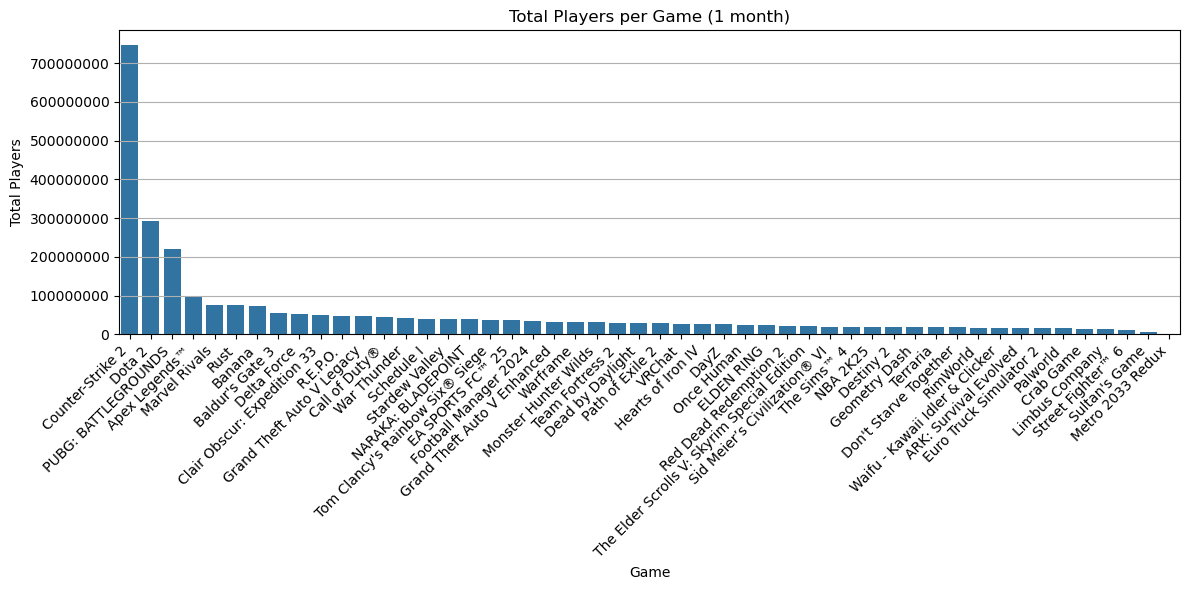

In [154]:
gameTotal = playerData.groupby("Game")["Player Count"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=gameTotal.index, y=gameTotal.values)

plt.title("Total Players per Game (1 month)")
plt.xlabel("Game")
plt.ylabel("Total Players")

# Format y-axis to plain numbers (no scientific notation)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

This barplot shows the total number of players per game for 1 month calculated by adding the player count for each game in the dataset every hour.

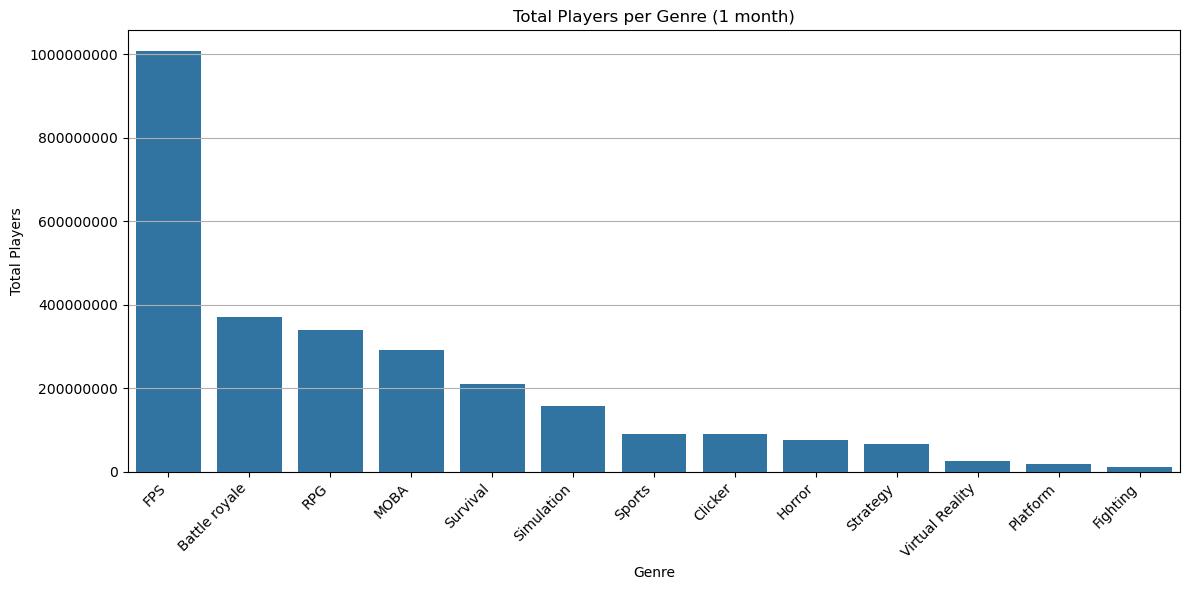

In [148]:
genreTotal = playerData.groupby("Genre")["Player Count"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genreTotal.index, y=genreTotal.values)

plt.title("Total Players per Genre (1 month)")
plt.xlabel("Genre")
plt.ylabel("Total Players")

# Format y-axis to plain numbers (no scientific notation)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

This barplot shows the total number of players per genre for 1 month calculated by adding the player count for each game in the dataset every hour.

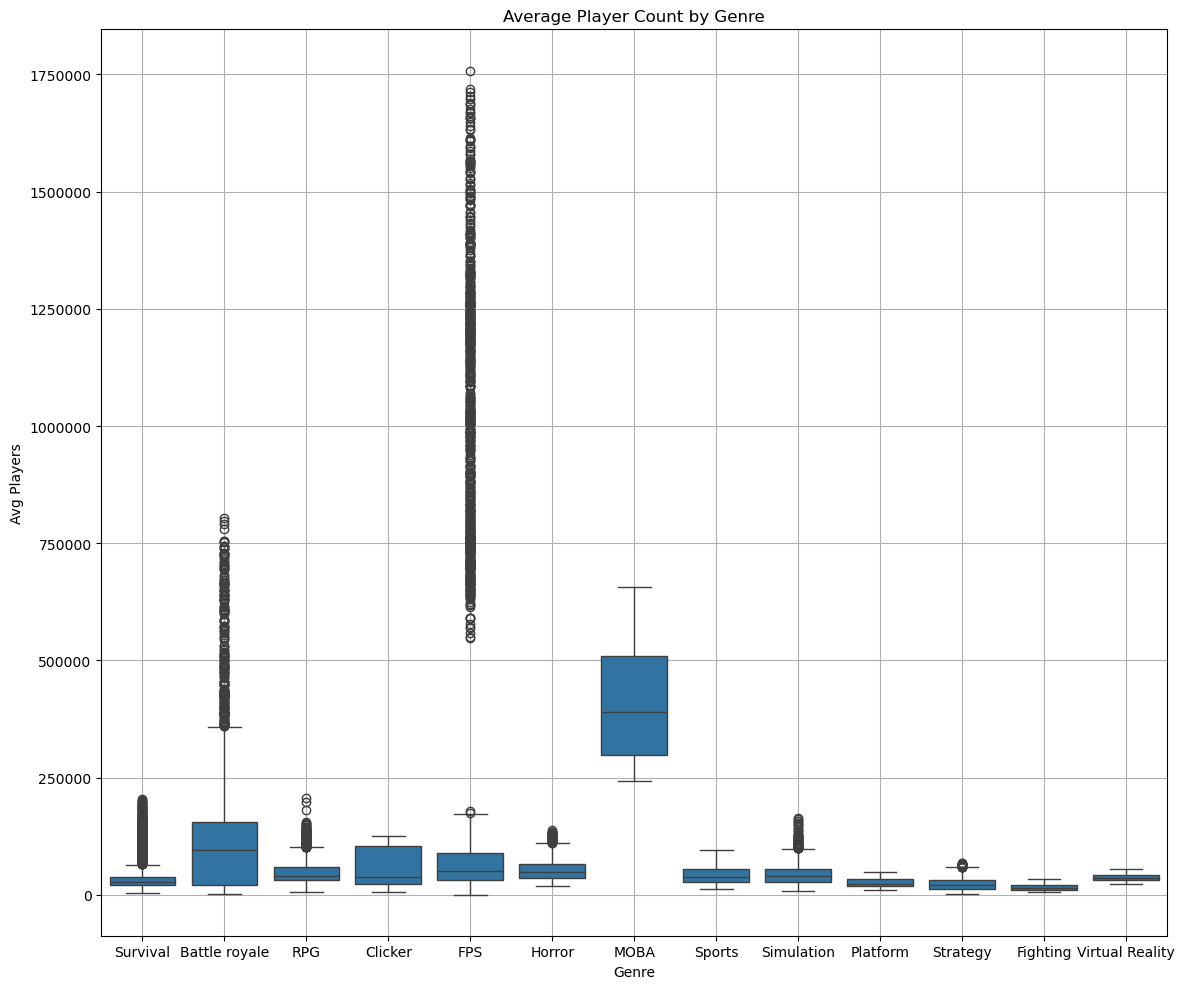

In [144]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=playerData, x="Genre", y="Player Count")

plt.title("Average Player Count by Genre")
plt.xlabel("Genre")
plt.ylabel("Avg Players")

# Force plain formatting for y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)
plt.tight_layout()
plt.show()

This boxplot shows the average playercount of each genre for 1 month.

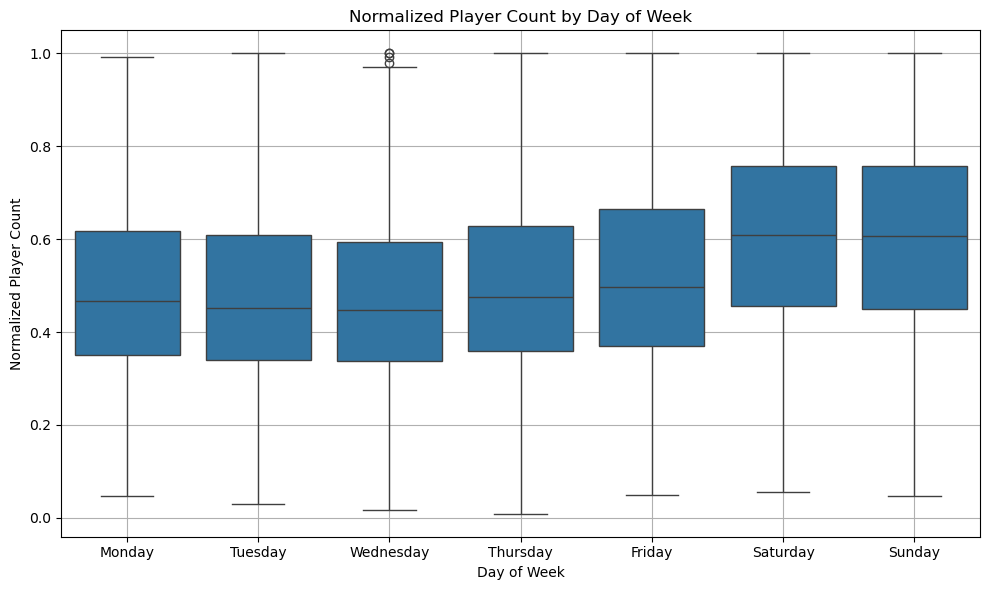

In [107]:
dayOrder = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6))
sns.boxplot(data=playerData, x="DayOfWeek", y="NormalizedPlayerCount", order=dayOrder)

plt.title("Normalized Player Count by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Normalized Player Count")
plt.grid(True)
plt.tight_layout()
plt.show()

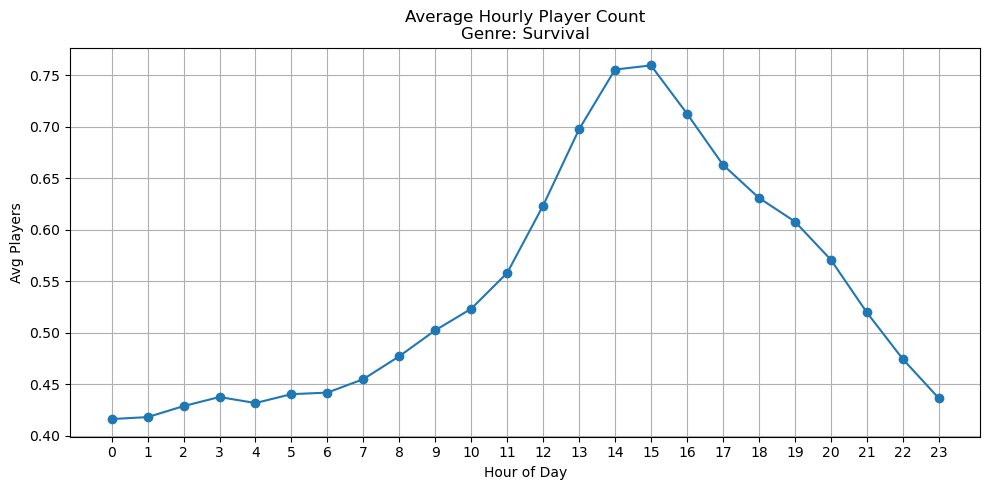

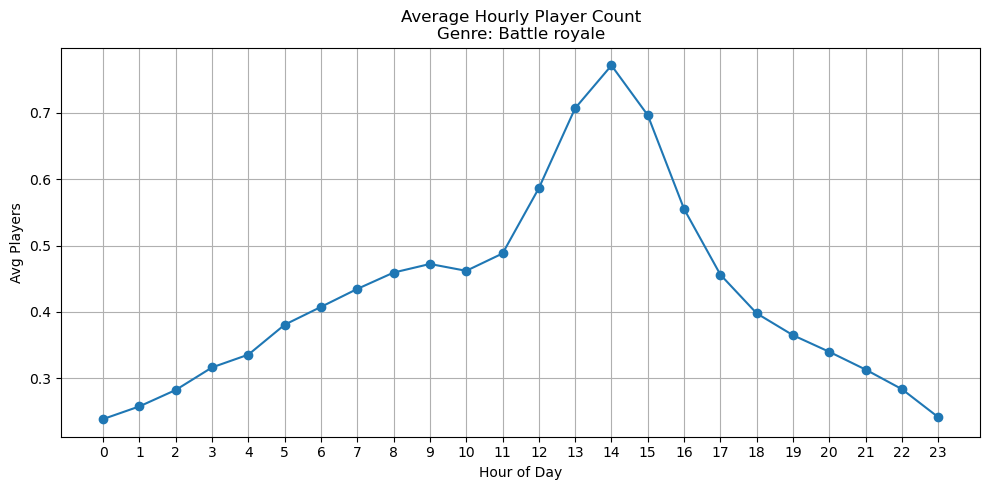

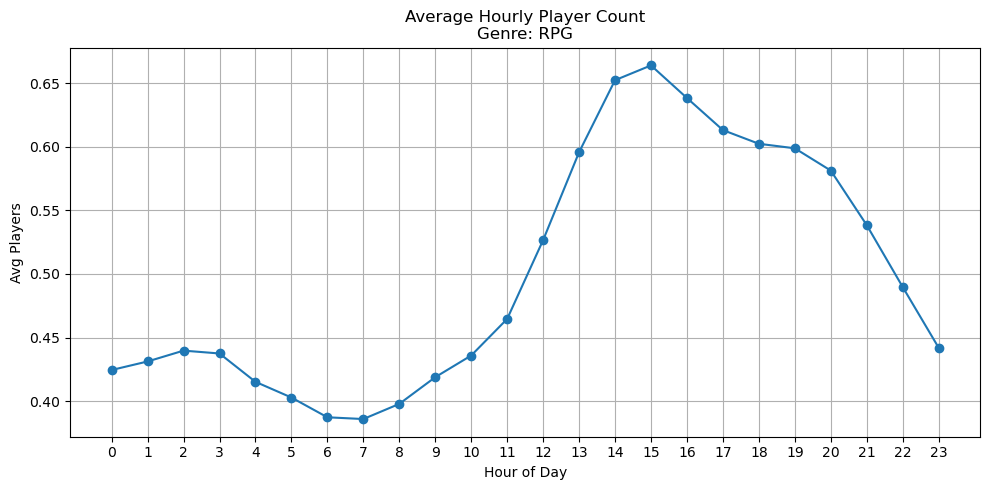

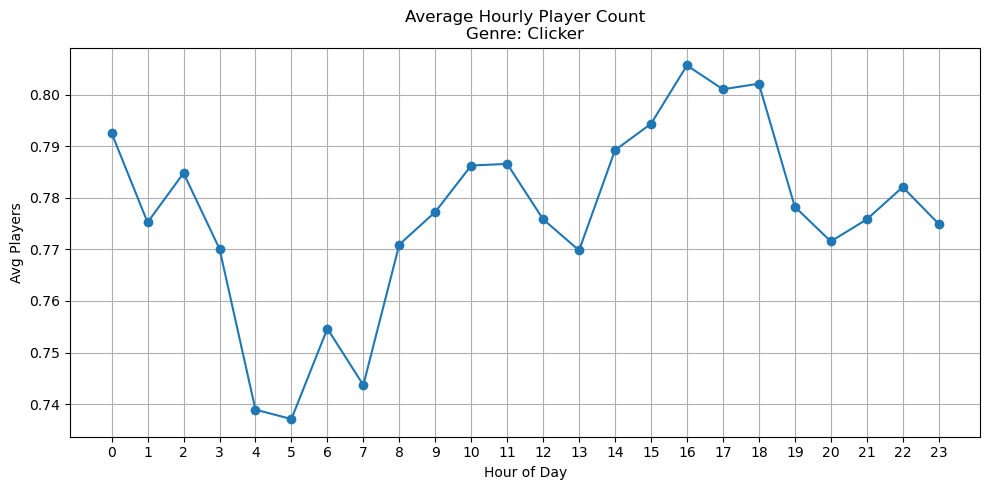

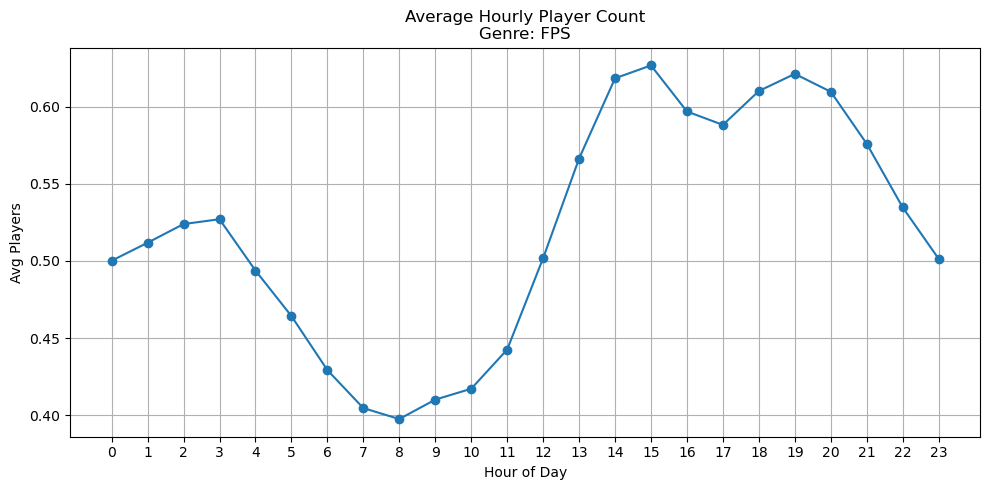

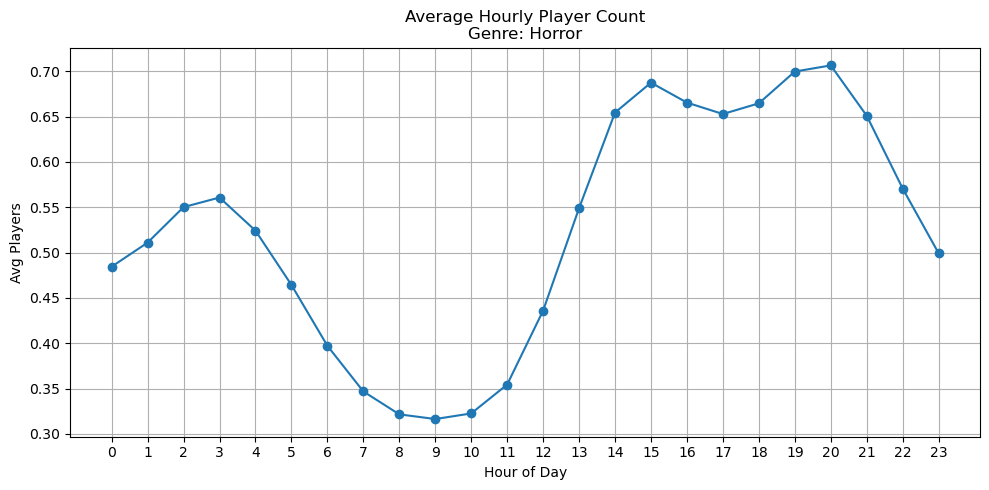

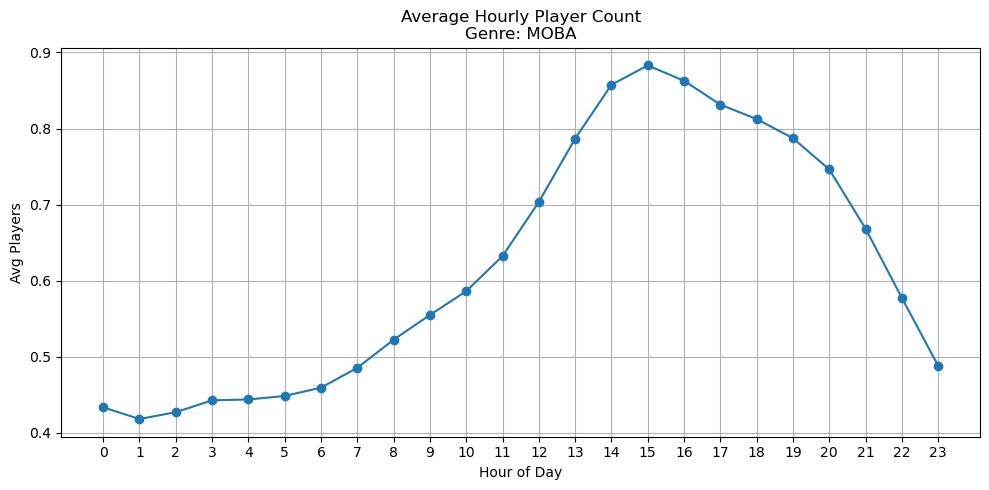

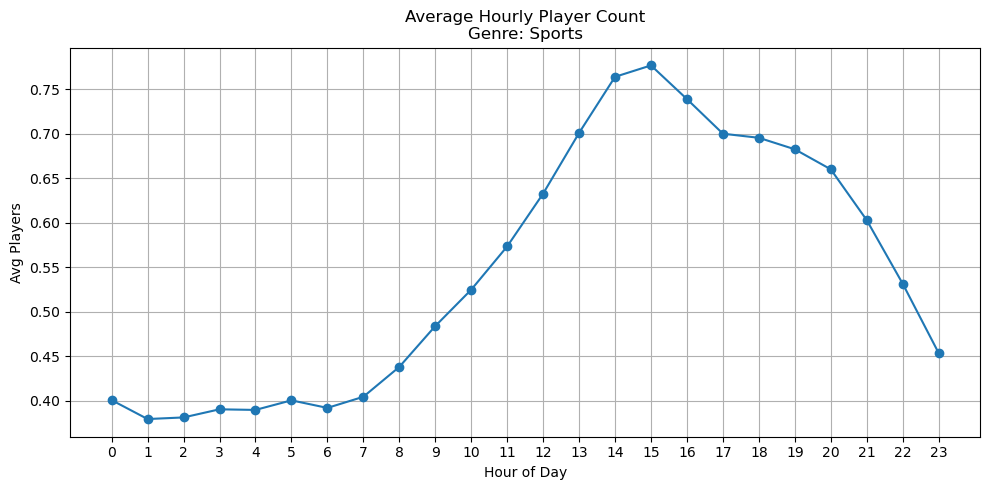

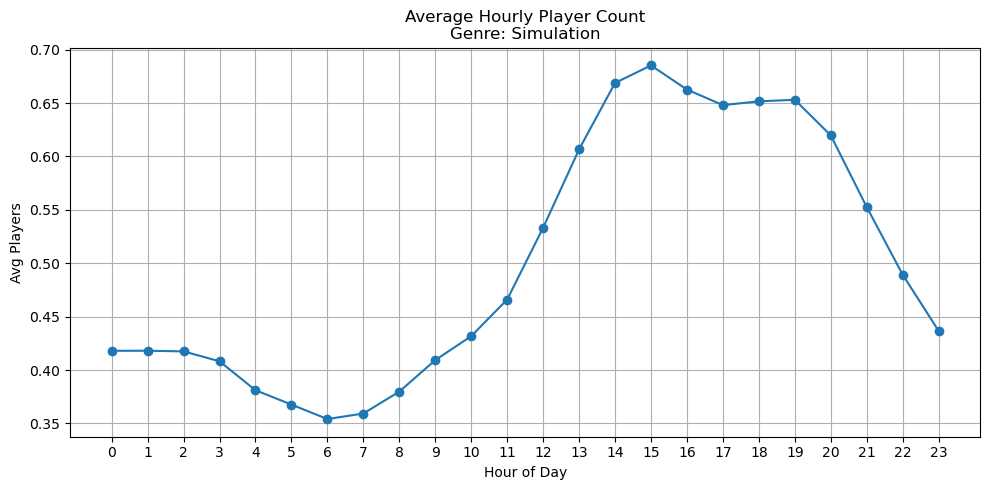

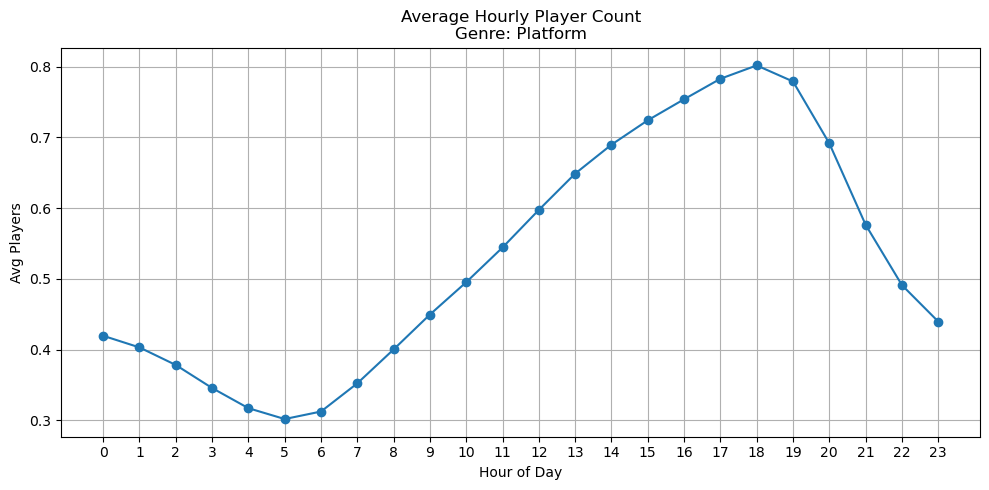

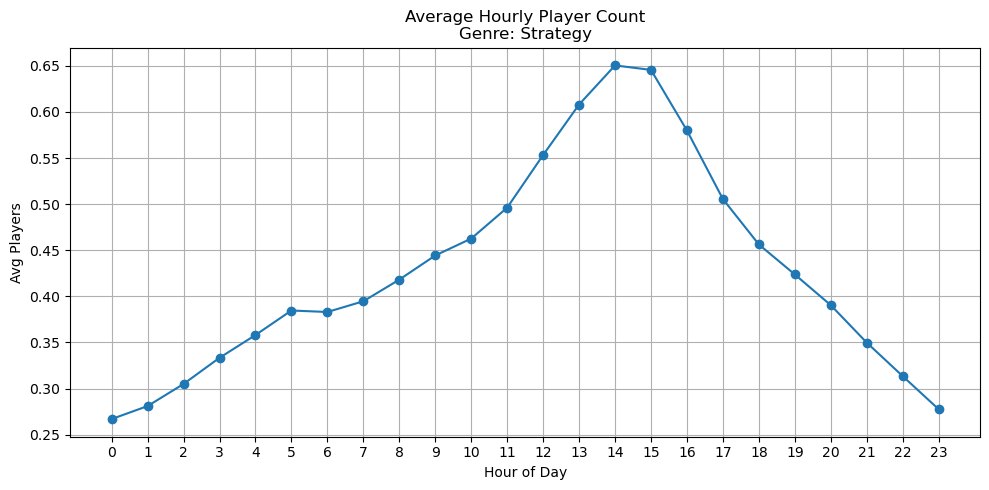

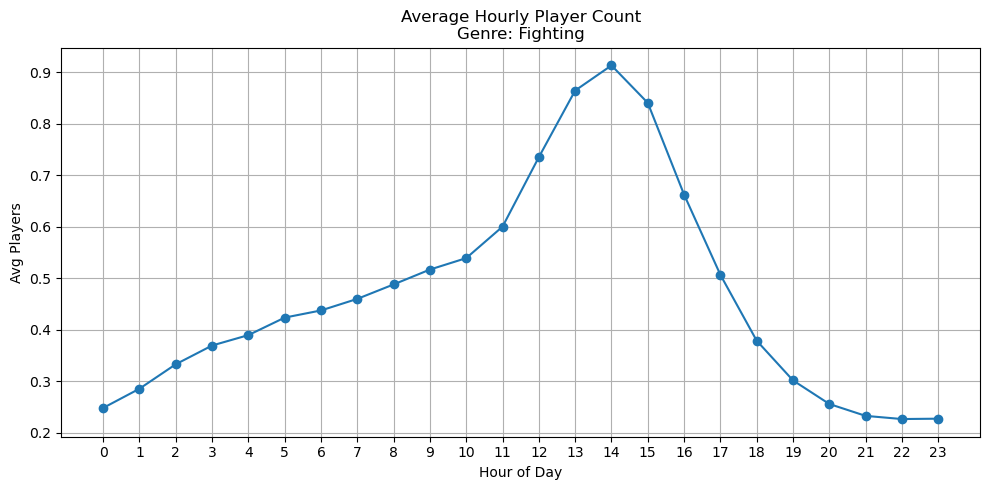

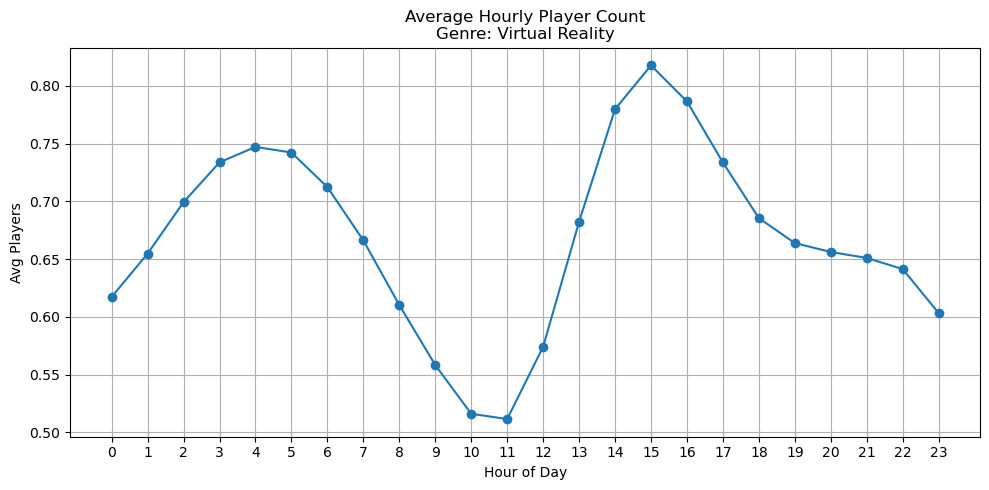

In [211]:
playerData["Hour"] = playerData["Date"].dt.hour

genres = playerData["Genre"].unique()

for genre in genres:
    genre_data = playerData[playerData["Genre"] == genre]
    hourly_avg = genre_data.groupby("Hour")["NormalizedPlayerCount"].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
    plt.xticks(range(0, 24))
    plt.title(f"Average Hourly Player Count\nGenre: {genre}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Players")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [180]:
result = stats.anderson(playerData["NormalizedPlayerCount"])
print(f"Anderson-Darling Test statistic: {result.statistic}")
print("Critical values and significance levels:")
for cv, sl in zip(result.critical_values, result.significance_level):
    print(f"  {sl}%: {cv}")

Anderson-Darling Test statistic: 51.983449493549415
Critical values and significance levels:
  15.0%: 0.576
  10.0%: 0.656
  5.0%: 0.787
  2.5%: 0.918
  1.0%: 1.092


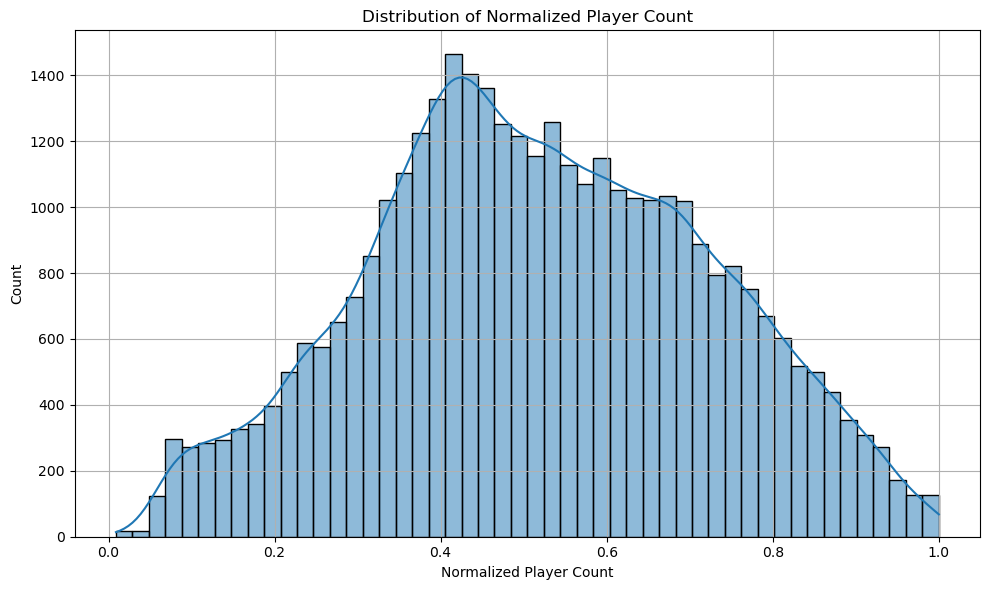

In [172]:
plt.figure(figsize=(10, 6))
sns.histplot(playerData["NormalizedPlayerCount"], kde=True, bins=50)
plt.title("Distribution of Normalized Player Count")
plt.xlabel("Normalized Player Count")
plt.grid(True)
plt.tight_layout()
plt.show()

From the above Anderson-Darling test showing a much higher statistic value than any of the significance levels and the visual representation not looking like the normal distribution we can conclude that the dataset doesn't follow a normal distribution, we will take this into consideration when we do further analysis.